In [1]:
cd ..

/Users/hyunminhong/Kalman-Heston-Filter


In [ ]:
from src.Utility import Utility, MeasurementType
from src.KalmanFilterSV import HestonKalmanFilter
from src.KalmanFilterCorr import HestonKalmanFilterCorr
from src.ParticleFilter import PFHeston
from src.Heston import *
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [3]:
# Set initial conditions and simulation parameters
S0 = 100
V0 = 0.04
params = {
    'mu': 0.05,
    'rho': -0.8,
    'kappa': 5.0,
    'theta': 0.04,
    'xi': 0.35
}
std_asy = np.sqrt(params['theta'] * params['xi']**2 / (2 * params['kappa']))
feller_cond = 2 * params['kappa'] * params['theta'] / params['xi']**2
print(round(feller_cond, 2))
assert feller_cond > 1, "Feller condition is violated!"

Hest = Heston(**params)
time_daily, S_daily, daily_returns, daily_true_V, daily_RV = Hest.path_simulation(
    S0, V0, T_years=10, trading_days=252, intraday_intervals=39, seed=40
)
R_daily = daily_returns.copy()

3.27


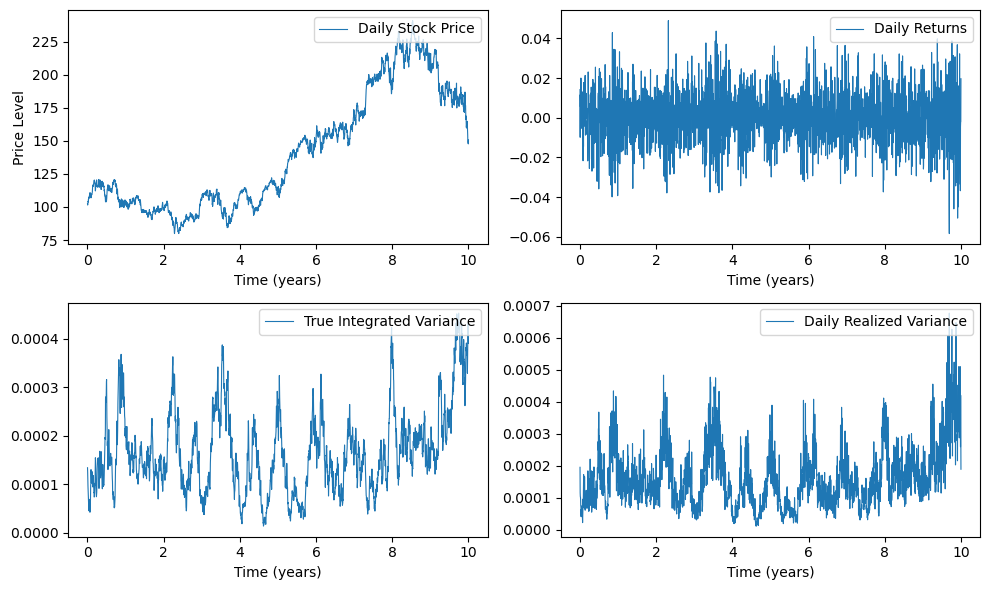

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# Subplot for BOTH measurements
axes[0,0].plot(time_daily, S_daily, label="Daily Stock Price", lw=0.8)
axes[0,0].set_xlabel("Time (years)")
axes[0,0].set_ylabel("Price Level")
axes[0,0].legend(loc="upper right")

# Subplot for RETURNS measurement
axes[0,1].plot(time_daily, daily_returns, label="Daily Returns", lw=0.8)
axes[0,1].set_xlabel("Time (years)")
axes[0,1].legend(loc="upper right")

# Subplot for RV measurement
axes[1,0].plot(time_daily, daily_true_V, label="True Integrated Variance", lw=0.8)
axes[1,0].set_xlabel("Time (years)")
axes[1,0].legend(loc="upper right")

# Subplot for RV measurement
axes[1,1].plot(time_daily, daily_RV, label="Daily Realized Variance", lw=0.8)
axes[1,1].set_xlabel("Time (years)")
axes[1,1].legend(loc="upper right")

plt.tight_layout()
plt.show()

In [24]:
daily_returns.shape

(2519,)

In [ ]:
burnin = 252
dt = 1  # Daily

split_index = 6 * 252 

# TRAINING SET 
train_returns = daily_returns[:split_index]
train_RV = daily_RV[:split_index]

# TEST SET 
test_returns = daily_returns[split_index:]
test_RV = daily_RV[split_index:]

TypeError: slice indices must be integers or None or have an __index__ method

### Both

In [ ]:
# Fit the model using training data
hkf_both = HestonKalmanFilter(measurement_type=MeasurementType.BOTH, dt=dt, V0=0.01, P0=0.1)
hkf_both.set_data(returns=train_returns, rv=train_RV)
initial_params_both = np.array([0.001, 0.001, 0.001, 0.001, 0.001]) 
# 1e-02, 1e-04, 8e-04, 4e-04, 3.16325904e-06

fit_results_both = hkf_both.fit(initial_params=initial_params_both, burnin=burnin)
params_opt_both = fit_results_both['params']
print("Optimized parameters (BOTH):", params_opt_both)

train_result_both = hkf_both.filter(params_opt_both)
last_V_train = train_result_both['V_filt'][-1]
last_P_train = train_result_both['P_filt'][-1]

hkf_both_test = HestonKalmanFilter(measurement_type=MeasurementType.BOTH, dt=dt, V0=last_V_train, P0=last_P_train)
V_filt_both_test = hkf_both_test.filter(params=params_opt_both, returns=test_returns, rv=test_RV)['V_filt']

### Both - Corr

In [7]:
hkf_both_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.BOTH, dt=dt, V0=0.01, P0=0.1)
hkf_both_corr.set_data(returns=train_returns, rv=train_RV)
initial_params_both_corr = np.array([0.015, 0.0001, 0.001, 0.001, 0.001, -0.1])
# initial_params_both_corr = np.array([0.1, 0.01, 0.01, 0.001, 0.001, -0.1])

fit_results_both_corr = hkf_both_corr.fit(initial_params=initial_params_both_corr, burnin=burnin)
params_opt_both_corr = fit_results_both_corr['params']
print("Optimized parameters (BOTH):", params_opt_both_corr)

train_result_both_corr = hkf_both_corr.filter(params_opt_both_corr)
last_V_train_corr = train_result_both_corr['V_filt'][-1]
last_P_train_corr = train_result_both_corr['P_filt'][-1]

hkf_both_test_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.BOTH, dt=dt, V0=last_V_train_corr, P0=last_P_train_corr)
test_result_both_corr = hkf_both_test_corr.filter(params=params_opt_both_corr, returns=test_returns, rv=test_RV)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.40799D+04    |proj g|=  6.31989D+04

At iterate    1    f= -1.40800D+04    |proj g|=  8.90000D-01

At iterate    2    f= -1.40807D+04    |proj g|=  8.90000D-01

At iterate    3    f= -1.40809D+04    |proj g|=  9.33195D+03

At iterate    4    f= -1.40817D+04    |proj g|=  4.31836D+04

At iterate    5    f= -1.40827D+04    |proj g|=  5.98415D+04

At iterate    6    f= -1.40839D+04    |proj g|=  3.01231D+04

At iterate    7    f= -1.40844D+04    |proj g|=  1.37080D+04

At iterate    8    f= -1.40849D+04    |proj g|=  1.19206D+04

At iterate    9    f= -1.40856D+04    |proj g|=  8.50659D+03

At iterate   10    f= -1.40866D+04    |proj g|=  2.92654D+03

At iterate   11    f= -1.40875D+04    |proj g|=  6.10994D+02

At iterate   12    f= -1.40877D+04    |proj g|=  5.24513D+01

At iterate   13    f= -1.4

/Users/hyunminhong/anaconda3/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0



QMLE Results for Heston Model:

--------------------------------------------------
kappa: 0.004782
theta: 0.000175
xi: 0.000736
mu: -0.000141
sigma: 0.000794
rho: -0.249358
Negative Log-Likelihood: -14095.583177
Convergence: True
--------------------------------------------------
Optimized parameters (BOTH): [ 4.78150939e-03  1.74830931e-04  7.36061814e-04 -1.41194636e-04
  7.94434020e-04 -2.49358107e-01]
At iterate   56    f= -1.40956D+04    |proj g|=  9.28594D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     56     64     61     0     0   9.286D+03  -1.410D+04
  F =  -14095.583176913207     

CONVERGENCE: 

### Return

In [ ]:
# Fit the model using training data
hkf_returns = HestonKalmanFilter(measurement_type=MeasurementType.RETURNS, dt=dt, V0=0.01, P0=0.1)
hkf_returns.set_data(returns=train_returns)
initial_params_returns = np.array([0.001, 0.001, 0.001, 0.001])

fit_results_returns = hkf_returns.fit(initial_params=initial_params_returns, burnin=burnin)
params_opt_returns = fit_results_returns['params']
print("Optimized parameters (RETURNS):", params_opt_returns)

train_result_returns = hkf_returns.filter(params_opt_returns)
last_V_returns = train_result_returns['V_filt'][-1]
last_P_returns = train_result_returns['P_filt'][-1]

hkf_returns_test = HestonKalmanFilter(measurement_type=MeasurementType.RETURNS, dt=dt, V0=last_V_returns, P0=last_P_returns)
V_filt_returns_test = hkf_returns_test.filter(params=params_opt_returns, returns=test_returns)['V_filt']

### Return - Corr

In [9]:
# Fit the model using training data
hkf_returns_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.RETURNS, dt=dt, V0=0.02, P0=0.1)
hkf_returns_corr.set_data(returns=train_returns)
initial_params_returns_corr = np.array([0.002, 0.0001, 0.007, 0.002, 0])

fit_results_returns_corr = hkf_returns_corr.fit(initial_params=initial_params_returns_corr, burnin=burnin)
params_opt_returns_corr = fit_results_returns_corr['params']
print("Optimized parameters (RETURNS):", params_opt_returns_corr)

train_result_returns_corr = hkf_returns_corr.filter(params_opt_returns_corr)
last_V_returns_corr = train_result_returns_corr['V_filt'][-1]
last_P_returns_corr = train_result_returns_corr['P_filt'][-1]

hkf_returns_test_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.RETURNS, dt=dt, V0=last_V_returns_corr, P0=last_P_returns_corr)
test_result_returns_corr = hkf_returns_test_corr.filter(params=params_opt_returns_corr, returns=test_returns)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.44150D+03    |proj g|=  1.94263D+05

At iterate    1    f= -3.69256D+03    |proj g|=  3.09308D+06

At iterate    2    f= -3.71053D+03    |proj g|=  1.17933D+01

At iterate    3    f= -3.73199D+03    |proj g|=  8.33425D+00

At iterate    4    f= -3.74928D+03    |proj g|=  9.90002D-01

At iterate    5    f= -3.74955D+03    |proj g|=  1.25676D+05

At iterate    6    f= -3.74981D+03    |proj g|=  9.90002D-01

At iterate    7    f= -3.74982D+03    |proj g|=  9.90002D-01

At iterate    8    f= -3.74985D+03    |proj g|=  2.27519D+04

At iterate    9    f= -3.74992D+03    |proj g|=  5.17813D+04

At iterate   10    f= -3.75012D+03    |proj g|=  1.04599D+05

At iterate   11    f= -3.75060D+03    |proj g|=  1.85213D+05

At iterate   12    f= -3.75180D+03    |proj g|=  3.04759D+05

At iterate   13    f= -3.7

### RV

In [10]:
hkf_rv = HestonKalmanFilter(measurement_type=MeasurementType.RV, dt=dt, V0=0.01, P0=0.1)
hkf_rv.set_data(rv=train_RV)
initial_params_rv = np.array([0.001, 0.001, 0.001, 0.001])

fit_results_rv = hkf_rv.fit(initial_params=initial_params_rv, burnin=burnin)
params_opt_rv = fit_results_rv['params']
print("Optimized parameters (RV):", params_opt_rv)

train_result_rv = hkf_rv.filter(params_opt_rv)
last_V_rv = train_result_rv['V_filt'][-1]
last_P_rv = train_result_rv['P_filt'][-1]

hkf_rv_test = HestonKalmanFilter(measurement_type=MeasurementType.RV, dt=dt, V0=last_V_rv, P0=last_P_rv)
test_result_rv = hkf_rv_test.filter(params=params_opt_rv, rv=test_RV)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.30126D+03    |proj g|=  1.88424D+06

At iterate    1    f= -9.94130D+03    |proj g|=  4.21464D+02

At iterate    2    f= -1.09044D+04    |proj g|=  3.53389D-03
  Positive dir derivative in projection 
  Using the backtracking step 

At iterate    3    f= -1.09704D+04    |proj g|=  3.04629D-03

At iterate    4    f= -1.09727D+04    |proj g|=  2.89063D-03

At iterate    5    f= -1.09741D+04    |proj g|=  1.99716D+00

At iterate    6    f= -1.09742D+04    |proj g|=  8.20053D+02

At iterate    7    f= -1.09746D+04    |proj g|=  2.56337D+03

At iterate    8    f= -1.09748D+04    |proj g|=  1.29803D+03

At iterate    9    f= -1.09748D+04    |proj g|=  1.71172D+02

At iterate   10    f= -1.09748D+04    |proj g|=  2.11972D+02

At iterate   11    f= -1.09748D+04    |proj g|=  2.62828D+02

At iterate   12 

### PF

In [11]:
pf_heston_train = PFHeston(train_returns, N=5000, dt=1/252, is_log=True)

param_bounds_train = [
    (-0.1, 0.1),    # mu
    (1, 5),        # kappa
    (0.02, 0.03),    # theta
    (0.1, 0.3),    # xi
    (-0.9, 0),        # rho
    V0              # v0
]

_, estimated_param = pf_heston_train.filter(param_bounds_train, predict_obs=False)
param_bounds = list(zip(estimated_param[:,-1] - 1e-3, estimated_param[:,-1] + 1e-3))

resampling since: 984.2857992198212
resampling since: 756.4679850865158
resampling since: 55.79851342293591
resampling since: 586.570072089752
resampling since: 358.705216368676
resampling since: 1144.3000433666725
resampling since: 3051.468314443572
resampling since: 2785.341942978259
resampling since: 1234.8301185918465
resampling since: 2862.05122246046
resampling since: 3330.3303188403897
resampling since: 2989.3024027803413
resampling since: 3476.8354116995715
resampling since: 2927.9781537834633
resampling since: 1625.9824278787148
resampling since: 3123.973331843753
resampling since: 1534.9102662491316
resampling since: 288.8681632674462
resampling since: 2340.033639541606
resampling since: 742.1970124985852
resampling since: 3463.92658677988
resampling since: 2071.1510354491566
resampling since: 3066.094630359158
resampling since: 2314.4616733175776
resampling since: 1150.024463791201
resampling since: 1767.9329537964402
resampling since: 2870.777832412828
resampling since: 157

In [12]:
pf_heston_test = PFHeston(test_returns, N=5000, dt=1/252, is_log=True)

V_pf_train, _ = pf_heston_train.filter([*param_bounds, V0], predict_obs=False)
V_pf_test, _ = pf_heston_test.filter([*param_bounds, V_pf_train[-1]], predict_obs=False)

resampling since: 2951.3820752082624
resampling since: 3431.566145040032
resampling since: 2411.388651956671
resampling since: 3164.9897926425274
resampling since: 3449.77054171399
resampling since: 3276.081934417864
resampling since: 3250.33192902804
resampling since: 2989.1927171662114
resampling since: 2734.035070995674
resampling since: 3498.113069711371
resampling since: 2328.451215285737
resampling since: 3261.9682376175247
resampling since: 3425.5338761433836
resampling since: 2943.253960519915
resampling since: 3375.4601049158637
resampling since: 2957.3251130455774
resampling since: 2848.9328403685954
resampling since: 3409.3648334003337
resampling since: 2379.1786583189187
resampling since: 3294.5403703441652
resampling since: 3377.6497603168914
resampling since: 3407.8780975556515
resampling since: 3352.6524972772636
resampling since: 3184.5950828196464
resampling since: 3326.3350580190363
resampling since: 2772.3356640491306
resampling since: 2529.692591381634
resampling si

In [17]:
V_pf_train_daily = V_pf_train / 400
V_pf_test_daily = V_pf_test / 400

## Plot

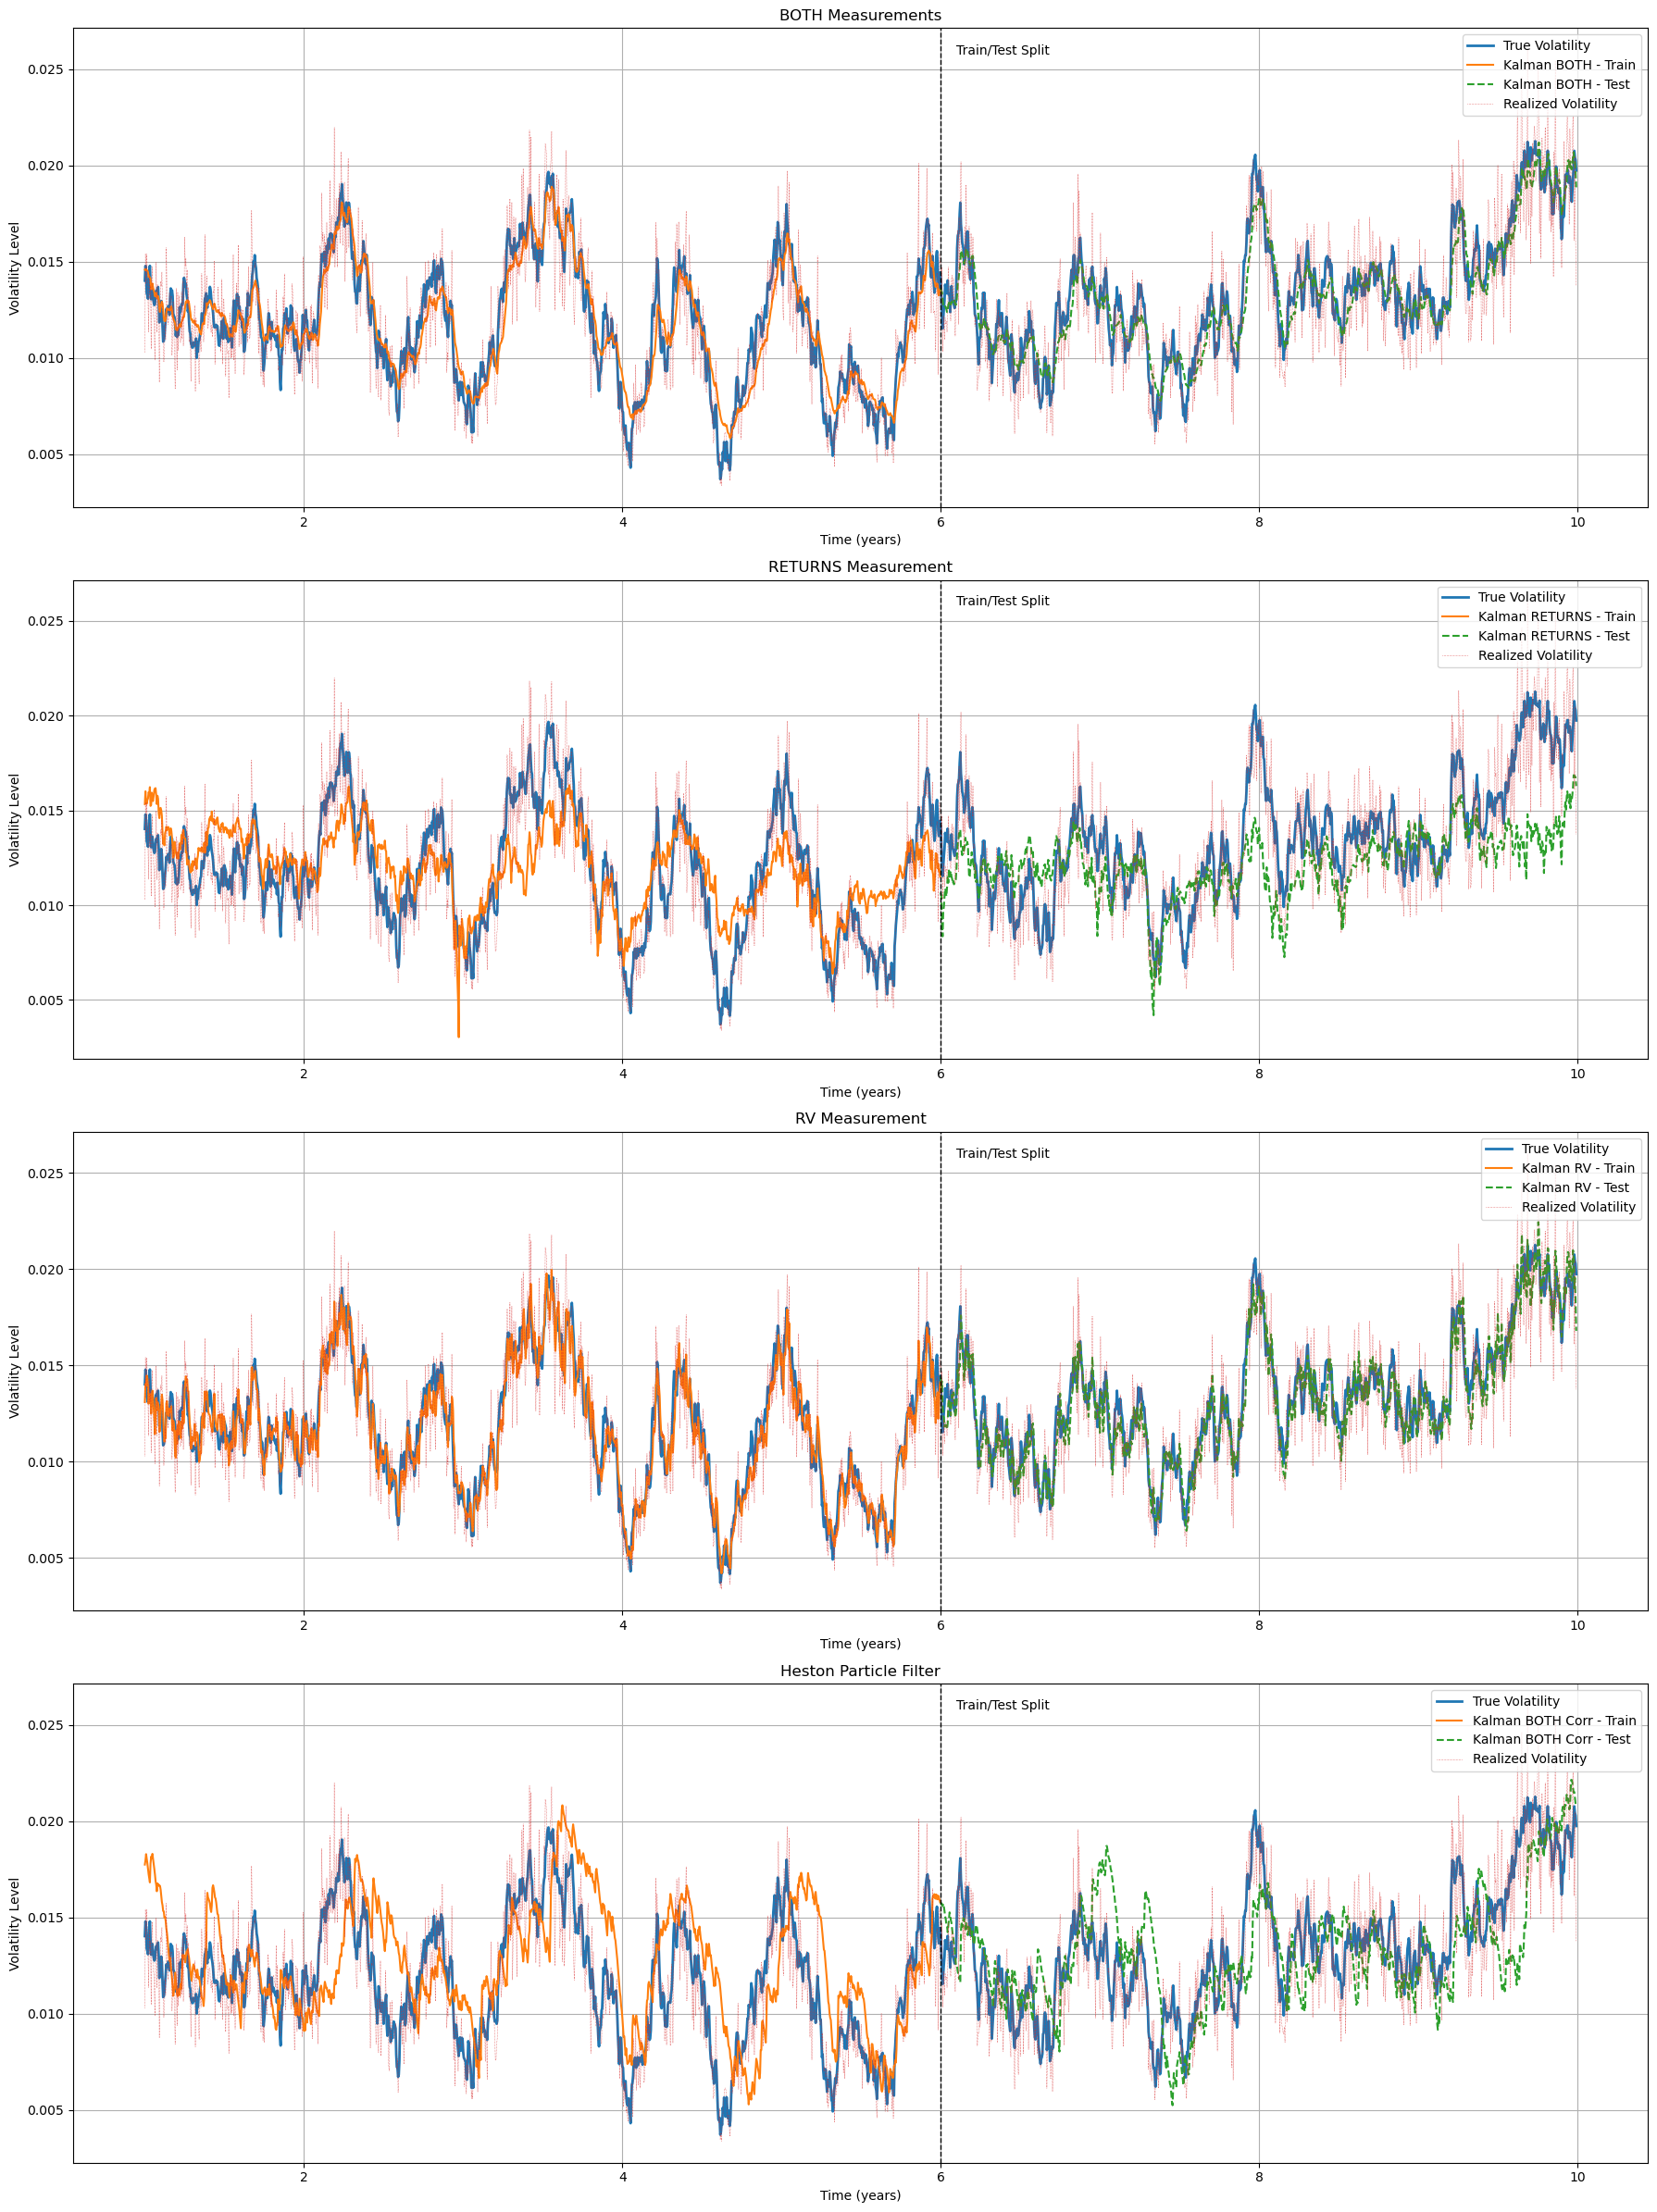

In [18]:
v_item = 'V_filt'

titles_all = ["BOTH Measurements", "RETURNS Measurement", "RV Measurement", "Heston Particle Filter"]
labels_all = ["Kalman BOTH", "Kalman RETURNS", "Kalman RV", "Kalman BOTH Corr", "Kalman RETURNS Corr", "PF Heston"]
train_all = [train_result_both_corr[v_item], train_result_returns_corr[v_item], train_result_rv[v_item], V_pf_train_daily]
test_all = [test_result_both_corr[v_item], test_result_returns_corr[v_item], test_result_rv[v_item], V_pf_test_daily]

Utility.plot_all_filters(
    titles=titles_all,
    labels=labels_all,
    train_filtered_list=train_all,
    test_filtered_list=test_all,
    daily_true_V=daily_true_V,
    daily_RV=daily_RV,
    daily_returns=daily_returns,
    split_index=split_index,
    burnin=252, 
    save_path=r"./output/base.png"
)

In [19]:
def qlike_loss(true_var, pred_var):
    y = np.asarray(true_var)
    h = np.asarray(pred_var)
    
    eps = np.finfo(float).eps
    ratio = y / (h + eps)
    return np.mean(ratio - np.log(ratio) - 1)

model_names = ['both_corr', 'returns_corr', 'rv', 'pf']
true_variances   = daily_true_V[split_index:]
true_volatilities = np.sqrt(true_variances)

mae_scores   = {}
rmse_scores  = {}
mape_scores  = {}
qlike_scores = {}

for name, pred_var in zip(model_names, test_all):
    pred_vol = np.sqrt(pred_var)
    
    mae_scores[name]   = mean_absolute_error(true_volatilities, pred_vol)
    rmse_scores[name]  = np.sqrt(mean_squared_error(true_volatilities, pred_vol))
    mape_scores[name]  = mean_absolute_percentage_error(true_volatilities, pred_vol) * 100
    qlike_scores[name] = qlike_loss(true_variances, pred_var)

print("Results including QLIKE:")
for name in model_names:
    print(f"{name:12s} MAE: {mae_scores[name]:.6f}, "
          f"RMSE: {rmse_scores[name]:.6f}, "
          f"MAPE: {mape_scores[name]:.3f}%, "
          f"QLIKE: {qlike_scores[name]:.6f}")


Results including QLIKE:
both_corr    MAE: 0.000816, RMSE: 0.001025, MAPE: 6.386%, QLIKE: 0.013733
returns_corr MAE: 0.002047, RMSE: 0.002654, MAPE: 14.598%, QLIKE: 0.088153
rv           MAE: 0.000723, RMSE: 0.000917, MAPE: 5.474%, QLIKE: 0.010506
pf           MAE: 0.002030, RMSE: 0.002597, MAPE: 16.004%, QLIKE: 0.087523


In [16]:
import pandas as pd
data = {}

data['both_corr'] = dict(zip(
    ['kappa', 'theta', 'xi', 'mu', 'sigma', 'rho'],
    params_opt_both_corr
))

data['returns_corr'] = dict(zip(
    ['kappa', 'theta', 'xi', 'mu', 'rho'],
    params_opt_returns_corr
))
data['returns_corr']['sigma'] = np.nan

data['rv'] = dict(zip(
    ['kappa', 'theta', 'xi', 'sigma'],
    params_opt_rv
))
data['rv']['mu']  = np.nan
data['rv']['rho'] = np.nan

pf_vals = estimated_param[:, -1]
data['pf'] = {
    'kappa': pf_vals[1],
    'theta': pf_vals[2],
    'xi':    pf_vals[3],
    'mu':    pf_vals[0],
    'rho':   pf_vals[4],
    'sigma': np.nan
}

cols = ['kappa', 'theta', 'xi', 'mu', 'sigma', 'rho']
df_params = pd.DataFrame.from_dict(data, orient='index')[cols]

df_params.T

,both_corr,returns_corr,rv,pf
kappa,0.004782,0.022690,0.010516,1.958337
theta,0.000175,0.000155,0.000141,0.025903
xi,0.000736,0.008351,0.001308,0.286305
mu,-0.000141,-0.000004,NaN,-0.029266
sigma,0.000794,NaN,0.002862,NaN
rho,-0.249358,0.000060,NaN,-0.136773


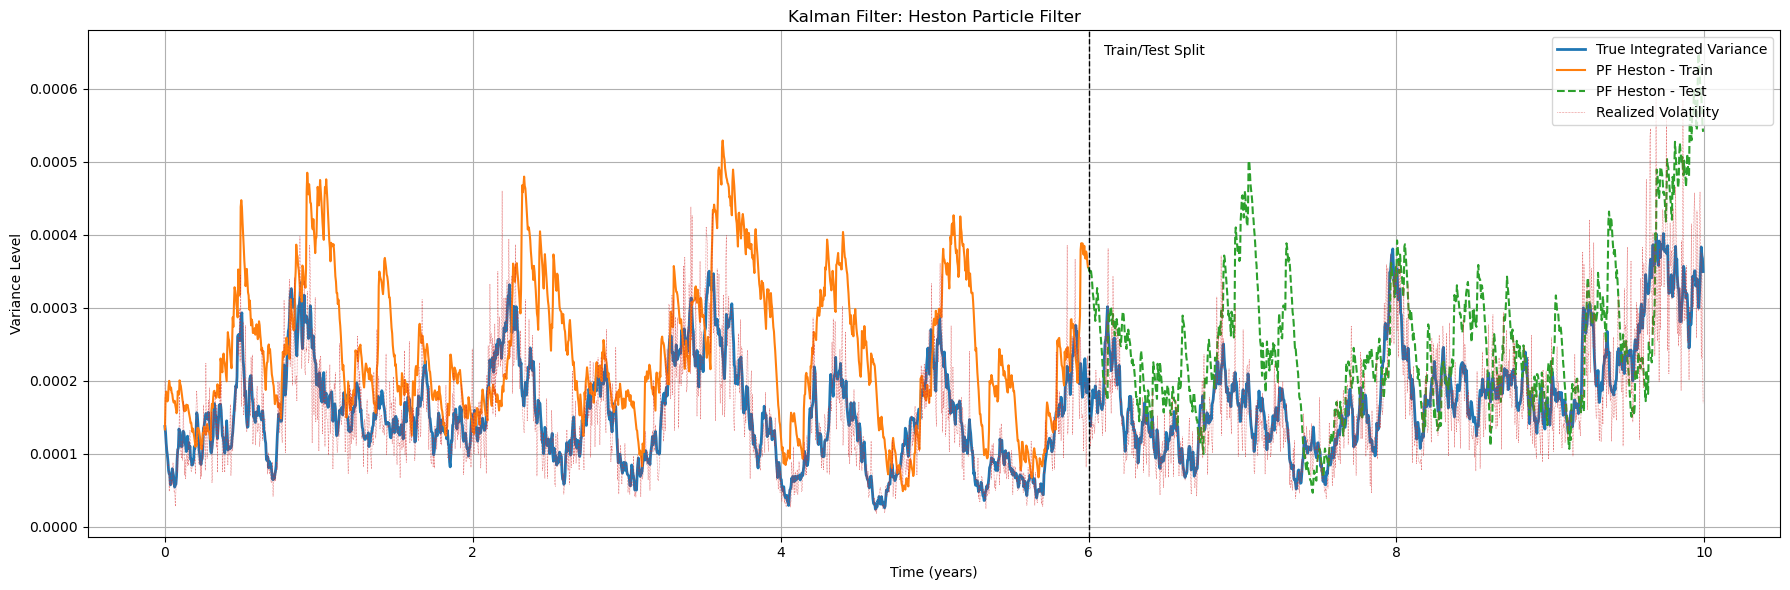

In-Sample RMSE (Heston Particle Filter): 0.000122
Out-of-Sample RMSE (Heston Particle Filter): 0.000110


(0.00012217167608488048, 0.00011009081122822449)

In [27]:
Utility.plot_filter_result(
    plot_index=5,
    titles=titles_all,
    labels=labels_all,
    train_filtered_list=train_all,
    test_filtered_list=test_all,
    daily_true_V=daily_true_V,
    daily_RV=daily_RV,
    daily_returns=daily_returns,
    split_index=split_index,
    burnin=0
)